# Recoloring CNN

## Import

In [1]:
import torch, os
import matplotlib.pyplot as plt
import torchvision.transforms as t
from PIL import Image, ImageOps
from pathlib import Path

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose
import torchvision.models as models

!pip install kornia
from turtle import color
from itertools import chain
from kornia.color import rgb_to_lab, lab_to_rgb
import numpy as np

## Data preprocessing

In [2]:
train_path = Path.cwd() / "train"
test_path = Path.cwd() / "test"

custom_blue_path = Path.cwd() / "c_blue"
blue_test_path = Path.cwd() / "c_blue_test"
custom_green_path = Path.cwd() / "c_green"
green_test_path = Path.cwd() / "c_green_test"
custom_yellow_path = Path.cwd() / "c_yellow"
custom_bgy_path = Path.cwd() / "c_bgy"
custom_val_path = Path.cwd() / "c_bgy_test"

In [3]:
def resize_with_padding(img, expected_size): # taken from https://stackoverflow.com/questions/43391205/add-padding-to-images-to-get-them-into-the-same-shape
    img.thumbnail((expected_size[0], expected_size[1]))
    delta_width = expected_size[0] - img.size[0]
    delta_height = expected_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [4]:
class Data(Dataset):
    def __init__(self, main_dir, transform):
         
        # Set the loading directory
        self.main_dir = main_dir
        self.transform = transform
        # List all images in folder and count them
        self.all_imgs = os.listdir(main_dir)
    
    def __len__(self):
        # Return the previously computed number of images
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])

        # Use PIL for image loading
        img = Image.open(img_loc).convert("RGB")
        
        # Apply transformations
        img = resize_with_padding(img, (256, 256))
        image = self.transform(img)

        # Turn RBG -> LAB
        img_lab = rgb_to_lab(image)
        
        # Extract l and ab channels into sepparate tensors
        img_ab = img_lab[1:3,:,:]
        img_ab = np.asarray(img_ab)
        img_ab = img_ab / 128
        img_ab = torch.from_numpy(img_ab).float()
        img_l = img_lab[0:1,:,:]
        img_l = np.asarray(img_l)
        img_l = img_l / 100
        img_l = torch.from_numpy(img_l).float()
        
        img_orig = image

        return img_orig, img_l, img_ab

In [5]:
def plot_images(org_input, l_input, ab_input, img_size = 256): #Ev add the original image as a plot
    '''Show rgb image from grayscale and ab channels'''
    
    # Genrate ab for grayscale plot
    bw_ab = torch.zeros((2,img_size,img_size))

    # Combine channels
    ab_input = np.asarray(ab_input)
    ab_input = ab_input *128
    ab_input = torch.from_numpy(ab_input).float()
    l_input = np.asarray(l_input)
    l_input = l_input * 100
    l_input = torch.from_numpy(l_input).float()
    color_image = torch.cat((l_input, ab_input), 0)
    bw_image = torch.cat((l_input, bw_ab), 0)
    
    # Lab -> RBG for plotting
    color_img = lab_to_rgb(color_image)
    bw_img = lab_to_rgb(bw_image)
    
    fig, axes = plt.subplots(1, 3, figsize=(12,4))
    
    print("Orignal image, Black and white, Our prediction")
    axes[0].imshow(org_input.permute(1, 2, 0), cmap='gray') # orignal picture
    
    axes[1].imshow(bw_img.permute(1, 2, 0), cmap='gray') # bw
    
    axes[2].imshow(color_img.permute(1, 2, 0), cmap='gray') # prediction

In [6]:
def plot_metrics(fig, ax, ns, train_losses, val_losses):

    # Plot losses
    ax.clear()
    ax.plot(ns, train_losses)
    ax.plot(ns, val_losses)
    
    ax.set_title('Loss')
    ax.legend(['Train','Validation'])
    ax.set_xlabel('Number of batches')
    ax.grid()
    
    fig.canvas.draw()

Orignal image, Black and white, Our prediction
torch.Size([3, 256, 256]) torch.Size([1, 256, 256]) torch.Size([2, 256, 256])


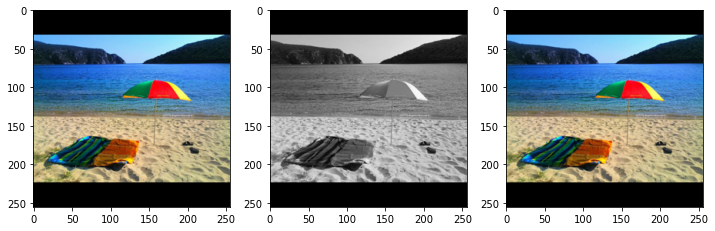

In [7]:
# Example usage
transform = Compose([t.ToTensor()])
#transform = Compose([t.ToTensor(), t.CenterCrop(256)])

example_dataset = Data(train_path, transform)

o, l, ab = example_dataset[450]
plot_images(o, l, ab)
print(o.shape, l.shape, ab.shape)

In [8]:
train_dataset = Data(train_path, transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = Data(test_path, transform)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)

blue_dataset = Data(custom_blue_path, transform)
blue_dataloader = DataLoader(blue_dataset, batch_size=2, shuffle=True)

green_dataset = Data(custom_green_path, transform)
green_dataloader = DataLoader(green_dataset, batch_size=2, shuffle=True)

green_test_dataset = Data(green_test_path, transform)
green_test_dataloader = DataLoader(green_test_dataset, batch_size=2, shuffle=True)

yellow_dataset = Data(custom_yellow_path, transform)
yellow_dataloader = DataLoader(yellow_dataset, batch_size=2, shuffle=True)

bgy_dataset = Data(custom_bgy_path, transform)
bgy_dataloader = DataLoader(bgy_dataset, batch_size=2, shuffle=True)

co_val_dataset = Data(custom_val_path, transform)
co_val_dataloader = DataLoader(co_val_dataset, batch_size=2, shuffle=True)

In [9]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=4, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        ## Upsampling
        self.decoder = nn.Sequential(
          nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(2),
          nn.Tanh(),
          nn.Upsample(scale_factor=8)
        )


    def forward(self, input):
        output_mid = self.encoder(input)
        output = self.decoder(output_mid)
        return output

model = Colorizer()

In [10]:
class AltColorizer(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        ## Upsampling
        self.decoder = nn.Sequential(
          nn.Conv2d(128, 2, kernel_size=3, stride=1, padding=1),
          nn.BatchNorm2d(2),
          nn.Tanh(),
          nn.Upsample(scale_factor=2) # Try to switch this for Convtranspose instead 
        )


    def forward(self, input):
        output_mid = self.encoder(input)
        output = self.decoder(output_mid)
        return output

model = AltColorizer()

In [11]:
class ResnetColorizer(nn.Module):
    def __init__(self):
        super(ResnetColorizer, self).__init__()
        MIDLEVEL_FEATURE_SIZE = 128
        
        ## ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])
        
        self.upsampling = nn.Upsample(scale_factor=2, mode='nearest')

        ## Upsampling and colorization
        self.upsample = nn.Sequential(     
            nn.Conv2d(in_channels=MIDLEVEL_FEATURE_SIZE,
                      out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=128, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            self.upsampling,
            nn.Conv2d(in_channels=64, out_channels=32,
                      kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(in_channels=32, out_channels=2,
                      kernel_size=(3, 3), stride=1, padding=1),
            self.upsampling
        )

    def forward(self, input):

        # ResNet - feature extraction
        midlevel_features = self.midlevel_resnet(input)

        # Upsampling and colorization
        output = self.upsample(midlevel_features)
        return output
    
model = ResnetColorizer()

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0)

Orignal image, Black and white, Our prediction


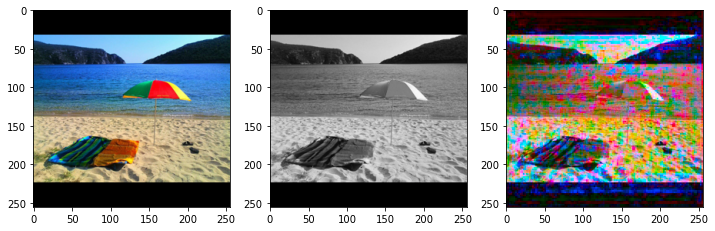

In [13]:
# Test a forward pass though the network
o, l, ab = example_dataset[450]
l_batch = torch.unsqueeze(l, 0)
ab_res = model.forward(l_batch).detach()
ab_res = torch.squeeze(ab_res, dim = 0)

plot_images(o, l, ab_res)

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
train_avg_

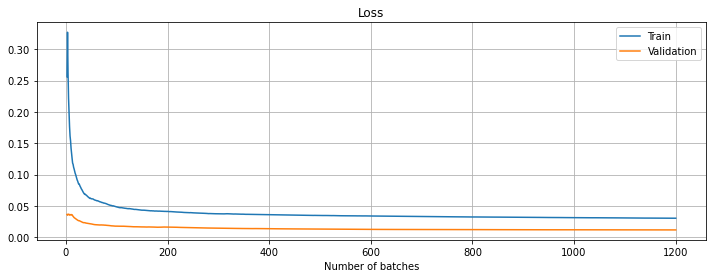

In [14]:
# Setup the figure for plotting progress during training
# %matplotlib notebook # for some reason conflicting the result picture

fig, ax = plt.subplots(ncols=1, figsize=(12,4))
plt.ion()
plot_interval = 1
batch_idxs, v_batch_idxs = [], []
batch, v_batch = 0, 0

losses, val_losses = [], []
train_data = {'losses': []}
val_data = {'losses': []}

# for overfitting
#for o, x, y in train_dataloader:
#    orig, b_l, b_ab = o.to(device), x.to(device), y.to(device)
#    break
    
model.train()
for epoch in range(100):
    for o, b_l, b_ab in bgy_dataloader: #train_dataloader:
        optimizer.zero_grad()
        pred_ab = model.forward(b_l)
    
        loss = loss_fn(pred_ab, b_ab)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    
        batch += 1
        
        if batch % plot_interval == 0:
            if (batch != plot_interval): # First value doen't make sense
                train_data['losses'].append((sum(losses)/len(losses)))
                batch_idxs.append(batch) 

    train_avg_loss = sum(losses)/len(losses) 
    
    # Compute predictions in the validation set (with adagrad deactivated)
    with torch.no_grad():
        for vo, vb_l, vb_ab in co_val_dataloader: #val_dataloader:
            val_pred = model.forward(vb_l)
            val_loss = loss_fn(val_pred, vb_ab)
            val_losses.append(val_loss.item())
            
            v_batch += 1
            
            if v_batch % plot_interval == 0:
                if (v_batch != plot_interval): # First value doen't make sense
                    val_data['losses'].append((sum(val_losses)/len(val_losses)))
                    v_batch_idxs.append(v_batch)
    
    val_avg_loss = sum(val_losses)/len(val_losses)  
    
    plot_metrics(fig, ax, batch_idxs, train_data['losses'], val_data['losses']) 
            
    print("Epoch:", epoch)   
print("train_avg_loss:", train_avg_loss ,"val_avg_loss:", val_avg_loss)

In [15]:
#Plot last image trained on (the overfitted data)
#for idx in range(len(b_l)):
#    plot_images(orig[idx], b_l[idx], pred_ab[idx].detach())

Orignal image, Black and white, Our prediction


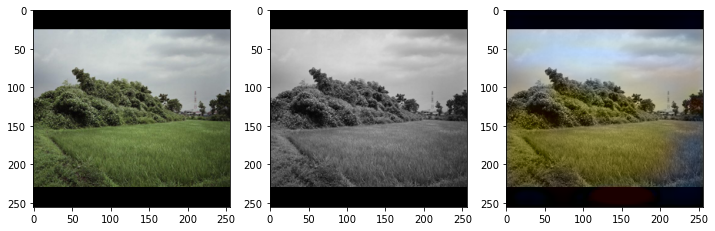

In [16]:
# Print a random image passed through the network 
with torch.no_grad():
    o, l, ab = example_dataset[1]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)

Orignal image, Black and white, Our prediction


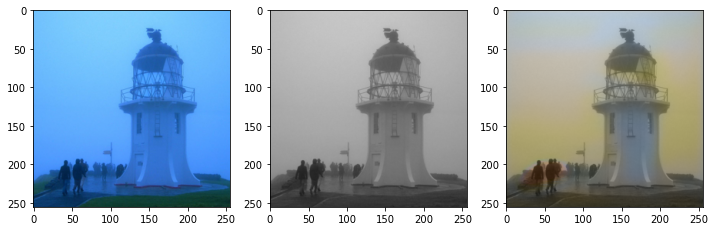

In [17]:
# Blue dataset 
with torch.no_grad():
    o, l, ab = blue_dataset[0]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)

Orignal image, Black and white, Our prediction


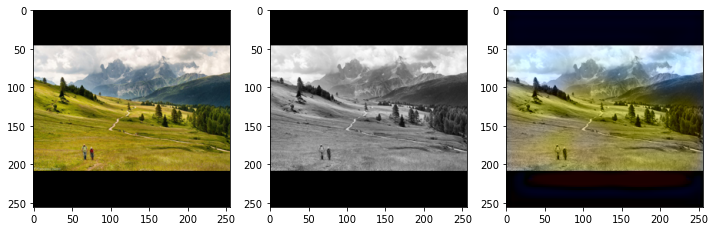

In [18]:
# Green dataset
with torch.no_grad():
    o, l, ab = green_dataset[3]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)

Orignal image, Black and white, Our prediction


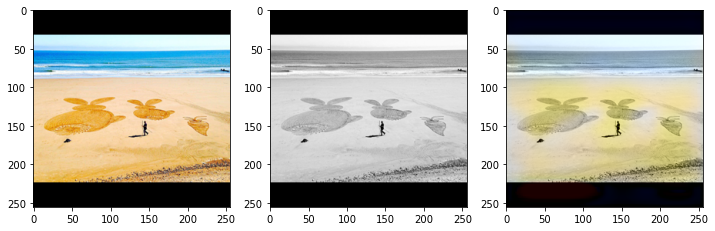

In [19]:
# yellow dataset
with torch.no_grad():
    o, l, ab = yellow_dataset[1]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)

Orignal image, Black and white, Our prediction


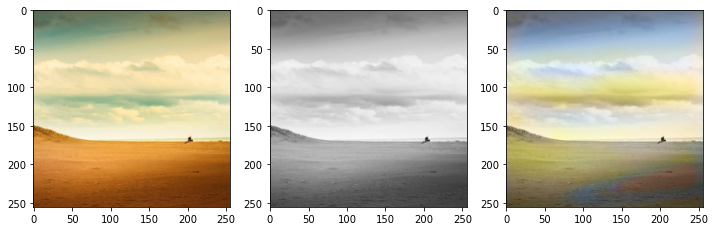

In [20]:
# combined dataset
with torch.no_grad():
    o, l, ab = bgy_dataset[0]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)

Orignal image, Black and white, Our prediction


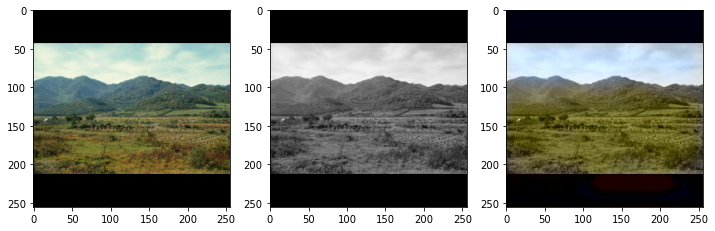

In [21]:
# Final test green # green never seen before
with torch.no_grad():
    o, l, ab = green_test_dataset[0]
    l_batch = torch.unsqueeze(l, 0)

    ab_res = model.forward(l_batch)
    ab_res = ab_res.cpu()
    ab_res = torch.squeeze(ab_res, dim = 0)
    plot_images(o, l, ab_res)